<a href="https://colab.research.google.com/github/christopher-ell/Deep_Learning_Begin/blob/master/10_Custom_Training_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough

**Summary**
1. Import and Parse the data
    - Import the data from tensorflow datasets
    - Transform it into a tensorflow dataset and specify how it will be broken into batches, how many epochs, whether it will be shuffled and other characteristics
2. Select The Type of Model
  - Create a neural network by stacking layers linearly separated by non-linear functions such as relu
  - Test out the model that currently has random parameters
3. Train the Model
  - Define the loss function and then using GradientTape() watch the loss function so you can later calculate the gradient wrt each parameter
  - Specify what method will be used to optimise the parameters including specifying what the learning rate of that method will be
  - Calculate the loss for each batch of examples, then calculate the gradient of that loss and adjust the parameters using that gradient and the method of optimisation specified above
  - Repeat the above iteration of updating the parameters until you have been through the data the number of epoch times
4. Evaluate The Model's Effectiveness
  - During the training track each epoch the loss and accuracy values
  - Extract the loss and accuracy values and plot them to view how those metrics improve over training
  - Import a test dataset (model that has never been used to train your model) and transform it into a tensor specifying batch size, shuffling, epochs and other settings.
  - Use the model trained on the training data to make predictions on the test data and track how accuracte these predictions are
5. Use The Trained Model to Make Predictions
  - Load some custom data, transforming it into a tensor and specifying how it will be run in the model
  - Load the custom data into the model and use it to make predictions.

In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager Execution: {}".format(tf.executing_eagerly()))

Tensorflow Version: 1.12.0
Eager Execution: True


**The Iris Classification Problem**

Import and Pars the Training Dataset

In [2]:
## Iris dataset is quite common so there is a link to it in standard tensforflow datasets
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
## Download Iris from tensorflow datasets and save it locally
train_dataset_fp = tf.keras.utils.get_file(fname = os.path.basename(train_dataset_url), 
                                          origin = train_dataset_url)

## Print where dataset is saved
print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /root/.keras/datasets/iris_training.csv


Inspect The Data

In [3]:
## Output the first 5 rows of data including the headings so it can be inspected
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [4]:
# Column order in csv file
## Save a list of column names for the dataset
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# Set all except last column names to feature names
feature_names = column_names[:-1]
## Set last column name to the label
label_name = column_names[-1]

## Print feature names for inspection
print("Features: {}".format(feature_names))
## Print label name for inspection
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [0]:
## Each number (1, 2, 3) in the species column of the data is associated with a
## label below called class names
class_names = ['Iris Setosa', 'Iris Versicolor', 'Iris Virginica']

Create a tf.data.dataset

In [6]:
## Tensorflows data API is able to transform data for loading into a model,
## transforming it so that it can be used in training

## Batch_size tells the model how many examples or datapoints to use for training
## at the same time.
batch_size = 32

## The make_csv_dataset() function loads CSV data into Tensorflow
train_dataset = tf.contrib.data.make_csv_dataset(
    ## Below is the dataset being formatted by tensorflow
    train_dataset_fp,
    ## Batch_size is the number of examples that the model looks at each point 
    ## while training
    batch_size,
    ## A list of strings corresponding to the CSV column names
    column_names = column_names,
    # A string corresponding to the correct label or the value the model is 
    ## trying to get
    label_name = label_name,
    ## An integer specifying the number of times the model runs through the data
    ## during training
    num_epochs = 1)

Instructions for updating:
Use `tf.data.experimental.make_csv_dataset(...)`.


In [7]:
features, labels = next(iter(train_dataset))

## The above function returns a formatted dataset where features are in a 
## dictionary of {'feature_name':values}
features

OrderedDict([('sepal_length',
              <tf.Tensor: id=68, shape=(32,), dtype=float32, numpy=
              array([6.3, 5.1, 6.8, 4.4, 5.4, 6.5, 6.4, 6.3, 5. , 7.3, 6.4, 4.8, 4.4,
                     6.4, 6.8, 7.7, 4.9, 7.6, 6.5, 7.2, 6.7, 6.3, 7.9, 5.4, 6.4, 5.1,
                     6. , 6.7, 4.6, 4.6, 5.7, 4.9], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=69, shape=(32,), dtype=float32, numpy=
              array([2.5, 2.5, 2.8, 3.2, 3.9, 3. , 2.7, 3.4, 3.4, 2.9, 3.2, 3. , 2.9,
                     2.8, 3. , 2.6, 3.1, 3. , 2.8, 3.2, 3.1, 2.3, 3.8, 3.7, 2.8, 3.8,
                     2.2, 3.1, 3.2, 3.6, 2.8, 3.1], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
              array([5. , 3. , 4.8, 1.3, 1.7, 5.5, 5.3, 5.6, 1.5, 6.3, 5.3, 1.4, 1.4,
                     5.6, 5.5, 6.9, 1.5, 6.6, 4.6, 6. , 4.4, 4.4, 6.4, 1.5, 5.6, 1.6,
                     5. , 5.6, 1.4, 1. , 4.5, 1.5],

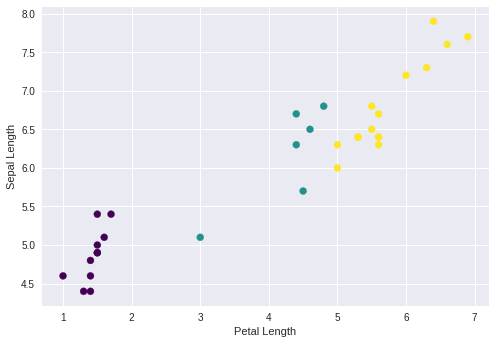

In [8]:
## Do a scatter plot so you can notice like features being grouped together

## Create a scatter plot of features petal_length vs sepal_length
plt.scatter(features['petal_length'],
           features['sepal_length'],
            ## Color 
           c = labels,
            ## Color map
           cmap = 'viridis')

## Make the x-axis "Petal Length"
plt.xlabel("Petal Length")
## Make the y-axis "Sepal Length"
plt.ylabel("Sepal Length");

In [0]:
## Takes the list of all tensors and stacks them into a single tensor
def pack_features_vector(features, labels):
  """Pack the features into a single array"""
  ## list() converts an iterable to a list
  ## stack() stacks a list of R tensors into a tensor of rank R + 1
  ## So this takes all the feature tensors and stacks them into a single feature
  ## tensor
  features = tf.stack(list(features.values()), axis = 1)
  return features, labels

In [0]:
## Test to see what above transformation does
#test, _ = pack_features_vector(features, labels)
#print(test)

In [11]:
## Map(func) applies the func to each element within the dataset 
## So the below applies the pack_feature_vector() operation to each element 
## within train_dataset
train_dataset = train_dataset.map(pack_features_vector)

## The iter() function creates an object that can be iterated one object at a 
## time
## The next() function returns the next item in an iterator
## SO the below iterates through the ddata moving onto the next item each time
features, labels = next(iter(train_dataset))

## Print the first 5 feature examples
print(features[:5])

tf.Tensor(
[[5.1 3.8 1.5 0.3]
 [5.  3.6 1.4 0.2]
 [5.8 2.8 5.1 2.4]
 [5.1 3.5 1.4 0.3]
 [7.6 3.  6.6 2.1]], shape=(5, 4), dtype=float32)


**Select The Type of Model**

In [12]:
## tf.keras.Sequential() is a function that linearly combines a stack of layers
model = tf.keras.Sequential([
    ## The first layer has 10 nodes and so 10 outputs with an input specified as
    ## 4 rows and however many columns and run the data through a relu function
    ## before passing it on to the next layer
    ## The parameters are equal to inputs (4) multiplied by nodes (10) plus 
    ## nodes (10) = 50
    tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape = (4,)), ## Input shape required
    ## The second layer has 10 nodes and so 10 outputs, it will take 10 inputs 
    ## from the layer before it and run the data through a relu function before
    ## passing it on to the next layer.
    ## This layer has 110 parameters (10 x 10 + 10)
    tf.keras.layers.Dense(10, activation = tf.nn.relu),
    ## The final layer has 3 nodes and so 3 outputs. It has 10 inputs from the 
    ## previous layer and doesn't have a non-linear function at the end
    ## the parameters = 10 x 3 + 3 = 33
    tf.keras.layers.Dense(3)
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


**Using The Model**

In [13]:
## Make some predictions with the untrained model

## Feed the features into the model
predictions = model(features)
## Output the first 5 prediction tensors each one returns a logit
predictions[:5]

<tf.Tensor: id=217, shape=(5, 3), dtype=float32, numpy=
array([[-2.8099854 ,  0.14638066,  2.4841747 ],
       [-2.695194  ,  0.09787536,  2.4007497 ],
       [-2.4783888 ,  0.87606144,  2.6059065 ],
       [-2.6440458 ,  0.09550345,  2.433379  ],
       [-3.1616611 ,  0.95119154,  3.2565322 ]], dtype=float32)>

In [14]:
## To convert the logits into probabilities the logits must be run through a 
## softmax (non linear function) which is logit over the sum of all logits
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=223, shape=(5, 3), dtype=float32, numpy=
array([[0.00455792, 0.08763959, 0.9078025 ],
       [0.00553437, 0.0903822 , 0.90408343],
       [0.00523297, 0.14981927, 0.8449477 ],
       [0.00565481, 0.08753652, 0.9068087 ],
       [0.00148145, 0.09054727, 0.9079713 ]], dtype=float32)>

In [15]:
## Output predictions by taking the prediction with the max probability
print("Predictions: {} ".format(tf.argmax(predictions, axis = 1)))
## Output the labels of the predictions
print("Labels: {} ".format(labels))

Predictions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 
Labels: [0 0 2 0 2 2 0 2 2 0 0 1 0 0 2 1 1 1 0 0 1 2 2 2 0 2 1 2 1 0 0 0] 


**Define The Loss and Gradient Function**

In [16]:
## Run the difference between the predictions and actual results through a loss
## function and sum them up
def loss(model, x, y):
  ## Generate predictions from the model
  y_ = model(x)
  ## Run the predictions and actual results through the
  ## sparse_softmax_cross_entropy loss model
  return tf.losses.sparse_softmax_cross_entropy(labels = y, logits = y_)

## Run the above loss model for all the feature data
l = loss(model, features, labels)
## Print the loss from the loss model based on all feature data
print("Loss test: {}".format(l))

Loss test: 2.7815802097320557


In [0]:
## Calculate the gradient of the loss function wrt each paramter
def grad(model, inputs, targets):
  ## Activate gradient tape so that each operation will be stored on the tape
  with tf.GradientTape() as tape:
    ## Run the loss model under activated grdient tape
    loss_value = loss(model, inputs, targets)
  ## Return the loss value and the gradient wrt each parameter
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
## Set up gradient descent algorithm with a learning rate of 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)

## Counter variable to count steps when optimising
global_step = tf.contrib.eager.Variable(0)

In [19]:
## Run and view the effects of gradient descent optimisation after 1 iteration

## Run the gradient function to get the losses and gradients
loss_value, grads = grad(model, features, labels)

## Output the curent step and initial loss value
print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                         loss_value.numpy()))

## The zip() function returns an iterator of tuples
## optimizer.apply_gradients() applies the gradients of the most recent loss 
## function to the model parameters 
optimizer.apply_gradients(zip(grads, model.variables), global_step)

## Output step and loss after an iteration of grdient descent optimisation
print("Step: {},         Loss: {}".format(global_step.numpy(),
                                         loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 2.7815802097320557
Step: 1,         Loss: 2.422778606414795


In [20]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
## Create empty list to append losses from model after each epoch
train_loss_results = []
## Create empty list to append accuracy from model after each epoch
train_accuracy_results = []

## Number of times optimiser will run through the data (epoch)
num_epochs = 201

## Will iterate through the data 201 times
for epoch in range(num_epochs):
  ## Store the function for calculating the mean in epoch_loss_avg
  epoch_loss_avg = tf.contrib.eager.metrics.Mean()
  ## Store the function for calculating the accuracy in epoch_accuracy
  epoch_accuracy = tf.contrib.eager.metrics.Accuracy()

  
  # Training loop - using batches of 32
  ## Iterate through the whole dataset running batches of 32 examples at a time
  for x, y in train_dataset:
    # Optimize the model
    ## Calculate the loss and gradients
    loss_value, grads = grad(model, x, y)
    ## Apply the gradients of the current loss function to all parameters to 
    ## hopefully bring them closer to optimal values
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step)

    # Track progress
    ## Calculate the loss at each epoch
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    ## Calculate the accuracy at each epoch
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type = tf.int32), y)

  # end epoch
  ## Once an epoch is run append the average loss to the list train_loss_results
  train_loss_results.append(epoch_loss_avg.result())
  ## Once an epoch is run append the average accuracy to the list 
  ## train_accuracy_results
  train_accuracy_results.append(epoch_accuracy.result())
  
  ## Every 50 epochs output a summary of accuracy and losses
  if epoch % 50 == 0:
    ## Output summary of where the model is up to in training as well as average 
    ## loss and accuracy for latest epoch
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


Epoch 000: Loss: 1.906, Accuracy: 35.000%
Epoch 050: Loss: 0.485, Accuracy: 70.000%
Epoch 100: Loss: 0.314, Accuracy: 93.333%
Epoch 150: Loss: 0.206, Accuracy: 98.333%
Epoch 200: Loss: 0.155, Accuracy: 97.500%


**Visualising The Loss Function Over Time**

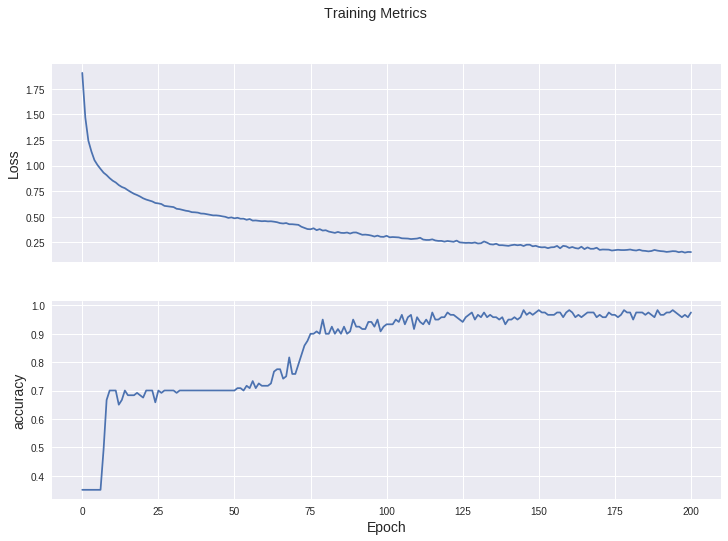

In [21]:
## plt.subplots() adds a subplot to the current figure storing that plot as fig
fig, axes = plt.subplots(2, sharex = True, figsize = (12, 8))
## Adds a subtitle to the figure fig of "Training Metrics"
fig.suptitle('Training Metrics')

## On the first plot label the Y-axis "Loss" at size 14 font
axes[0].set_ylabel("Loss", fontsize = 14)
## Plot the train_loss_results on the first plot
axes[0].plot(train_loss_results)

## On the second plot label the Y-axis "accuracy"
axes[1].set_ylabel("accuracy", fontsize = 14)
## On the second plot label the X-axis "Epoch"
axes[1].set_xlabel("Epoch", fontsize = 14)
## On the second graph plot the train_accuracy results
axes[1].plot(train_accuracy_results);

**Evaluate The Models Effectivness**

Setup The Test Dataset



In [22]:
## Download the test iris data. Additional data not used in the training process
## to test out the model with out of sample data
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname = os.path.basename(test_url), origin = test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [0]:
## The make_csv_dataset loads csv's into tensorflow
test_dataset = tf.contrib.data.make_csv_dataset(
    ## This time we are loading in the test data 
    test_fp,
    ## batch_size specifies how many examples/ data points will be processed at
    ## once.
    batch_size,
    ## column_names is a list of strings representing the names of each column
    column_names = column_names,
    ## label_name is the name of the value the model is trying to predict
    label_name = 'species',
    ## num_epochs is the number of times the training will run through the data
    num_epochs = 1,
    ## shuffle tells tensorflow to switch the order of the data every training
    shuffle = False)

## pack_features_vector takes all the tensors in test_dataset and packs them 
## into one. Map() does this for every value in the tensor
## So each value in the tensor is being packed into one tensor
test_dataset = test_dataset.map(pack_features_vector)

Evaluate The Model on The Test Data

In [24]:
## assign accuracy testing function to test_accuracy
test_accuracy = tf.contrib.eager.metrics.Accuracy()

## loop through each datapoint in the test dataset
for (x, y) in test_dataset:
  ## Run the explanatory data through the model
  logits = model(x)
  ## Find the prediction by taking the label with the highest probability
  prediction = tf.argmax(logits, axis = 1, output_type = tf.int32)
  ## Compare the prediction to the actual value to compare how often they match
  test_accuracy(prediction, y)
  
## Output the accuracy of predictions (correct_predictions/all_predictions)
print("Test set accuracy: {:.3f}".format(test_accuracy.result()))

Test set accuracy: 0.967


**Use The Trained Model to Make Predictions**

In [25]:
## convert some fresh data to a tensor
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1,]
])

## Use the model to make some predictions with this new data
predictions = model(predict_dataset)

## Loopthrough all predictions using enumerate() to get two things at once from
## the data the prediction number and the actual prediction
for i, logits in enumerate(predictions):
  ## Choose the label with the highest probability
  class_idx = tf.argmax(logits).numpy()
  ## Put the highest probability over the sum of all other probabilities 
  ## (softmax)
  p = tf.nn.softmax(logits)[class_idx]
  ## Look up the name of the predcted class
  name = class_names[class_idx]
  ## Output the prediction number, label and probability
  print("Example {} predictions: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 predictions: Iris Setosa (98.5%)
Example 1 predictions: Iris Versicolor (93.6%)
Example 2 predictions: Iris Virginica (56.1%)
